In [2]:
import math
import os
import pickle
import time

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
from torch import device
from torch.utils.data import Dataset, DataLoader, Subset
from torchmetrics.classification import MulticlassAccuracy
from tqdm import tqdm

from src.efficient_kan.kan import KAN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# CREATING DATASET FROM FUNCTION

In [3]:
class FunctionDataset(Dataset):
    def __init__(self, fun, length, domain_range: tuple[int, int]):
        self.fun = fun
        self.length = length
        self.domain_range = domain_range

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return self.fun(idx / self.length * (self.domain_range[1] - self.domain_range[0]) + self.domain_range[0])

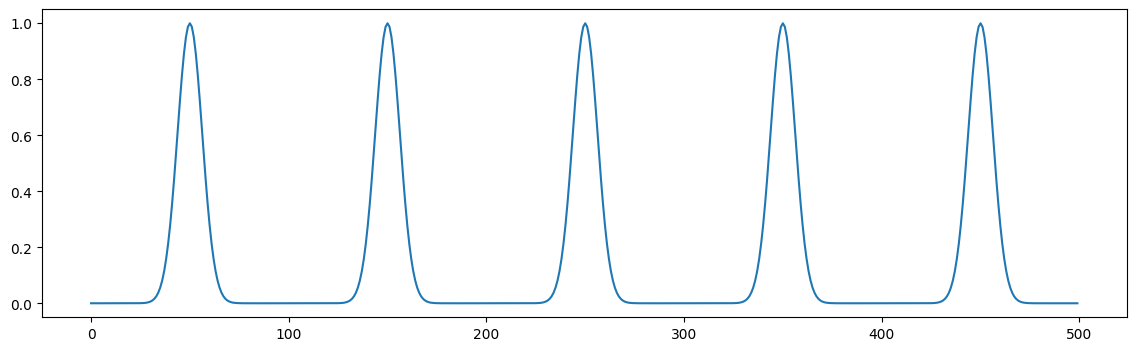

In [12]:
batch_size = 10
n_num_per_peak = 100
num_batches = 5 * 100 // batch_size
dataset_size = batch_size * num_batches
means = [-.8, -.4, 0, .4, .8]
variances = [.025, .025, .025, .025, .025]
function = lambda x: sum(
    math.exp(-(x - mean) ** 2 / (2 * variance ** 2)) for mean, variance in zip(means, variances))
dataset = FunctionDataset(fun=function, length=dataset_size, domain_range=(-1, 1))
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# MultiTask training sets
train_loader_tasks = [
    DataLoader(Subset(dataset, range(dataset_size // 5 * k, dataset_size // 5 * (k + 1))), batch_size=batch_size,
               shuffle=False)
    for k in range(5)]

plt.figure(figsize=(14, 4))
plt.plot(np.concatenate([x.numpy() for x in train_loader], axis=0))
plt.show()

In [5]:
# MLP
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = [1, 256, 256, 1]
        self.fc1 = nn.Linear(self.layers[0], self.layers[1])
        self.fc2 = nn.Linear(self.layers[1], self.layers[2])
        self.fc3 = nn.Linear(self.layers[2], self.layers[3])

    def forward(self, x):
        x = x / dataset_size * 2 - 1
        x = x.view(-1, self.layers[0])
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
# KAN
class Efficient_KAN(nn.Module):
    def __init__(self, grid_size=200):
        super(Efficient_KAN, self).__init__()
        self.layers = [1, 1]
        self.model = KAN(self.layers,
                         grid_size=grid_size,
                         grid_eps=1,
                         scale_base=0,
                         sp_trainable=False,
                         sb_trainable=False,
                         # enable_standalone_scale_spline=False
                         ).to(device)
        self.double()

    def forward(self, x):
        x = x / dataset_size * 2 - 1
        x = x.view(-1, self.layers[0])
        x = self.model(x)
        return x

# TRAIN() AND TEST() FUNCTIONS

In [7]:
def train(model, checkpoint, optimizer, start_epoch=0, epochs=5, on_epoch_end=None, lr=0, loader=None,
          task_id=None):
    if loader is None:
        loader = train_loader
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
    for epoch in range(start_epoch, epochs + start_epoch):
        model.train()
        epoch_start = time.time_ns()
        with tqdm(loader) as pbar:
            for i, y in enumerate(pbar):
                x = torch.linspace(batch_size * i, batch_size * (i + 1) - 1, steps=batch_size).to(device)
                if task_id is not None:
                    x += task_id * dataset_size // len(train_loader_tasks)
                y = y.to(device)
                optimizer.zero_grad()
                output = model(x)
                output = output.squeeze()
                loss = criterion(output, y)
                # loss = criterion(output.float(), y.view(-1, ).float())
                loss.backward()
                optimizer.step(closure=lambda: loss)
                pbar.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]['lr'])
                scheduler.step()
        # print(f'Epoch {epoch + 1}, Loss: {loss.item()}')
        epoch_duration = (time.time_ns() - epoch_start) // 1000000
        if on_epoch_end is not None and epoch % 9 == 0:
            on_epoch_end(model, epoch, loss.item(), epoch_duration, lr, task_id)

In [8]:
def test(model):
    model.eval()
    predictions = []
    ground_truths = []
    with torch.no_grad():
        for i, y in enumerate(train_loader):
            x = torch.linspace(batch_size * i, batch_size * (i + 1) - 1, steps=batch_size).to(device)
            ground_truths.extend(y.numpy())
            out = model(x).cpu()
            predictions.extend(out.view(-1).numpy())

    plt.figure(figsize=(14, 2))
    plt.plot(ground_truths)
    plt.plot(predictions)
    plt.show()
    return ground_truths, predictions

# INTRA and INTER DATASET TESTS
This class holds all relevant information about a training + test epoch. All the information needed to compute a confusion matrix is stored in the labels[] and predictions[] lists. Each serialised file takes about 300KiB, so they were added to the gitignore file.

In [9]:
class EpochStat:
    @staticmethod
    def loadModelStats(name, dir=f'results/gaussian_peaks/', subdir='') -> list['EpochStat']:
        return sorted([pickle.load(open(f'{dir}{subdir}{file}', 'rb')) for file in
                       filter(lambda e: name == '_'.join(e.split('_')[:-1]), os.listdir(f'{dir}{subdir}'))],
                      key=lambda e: e.epoch)

    def __init__(self, name, epoch, train_loss=0, test_loss=0, labels=None, predictions=None, epoch_duration=0, lr=0,
                 train_losses=None, train_accuracies=None, task_id=None):
        self.name = name
        self.train_loss = train_loss
        self.test_loss = test_loss
        self.epoch = epoch
        self.predictions = predictions
        self.labels = labels
        self.epoch_duration = epoch_duration
        self.lr = lr
        self.train_losses = train_losses
        self.train_accuracies = train_accuracies
        self.task_id = task_id

    def save(self, dir=f'results/gaussian_peaks/'):
        os.makedirs(dir, exist_ok=True)
        pickle.dump(self, open(f'{dir}{self.name}_epoch{self.epoch}.pickle', 'wb'))

    def get_accuracy(self):
        accuracy = 0
        for label, prediction in zip(self.labels, self.predictions):
            if label == prediction:
                accuracy += 1
        return accuracy / len(self.labels)


def onEpochEnd(model, epoch, train_loss, epoch_duration, lr, task_id):
    labels, predictions = test(model)
    (EpochStat(model.__class__.__name__, epoch, train_loss, None, labels, predictions, epoch_duration,
               lr, [], [], task_id)
    .save(
        dir=f'results/gaussian_peaks/intra/lr_{round(math.log10(lr))}/' if task_id is None else f'results/gaussian_peaks/inter/lr_{round(math.log10(lr))}/'))

## INTER DATASET TEST

Using lr=0.03 ------------------------------------
Training model=Efficient_KAN
Training on task 0


100%|██████████| 10/10 [00:00<00:00, 152.94it/s, loss=0.0126, lr=0.0297]


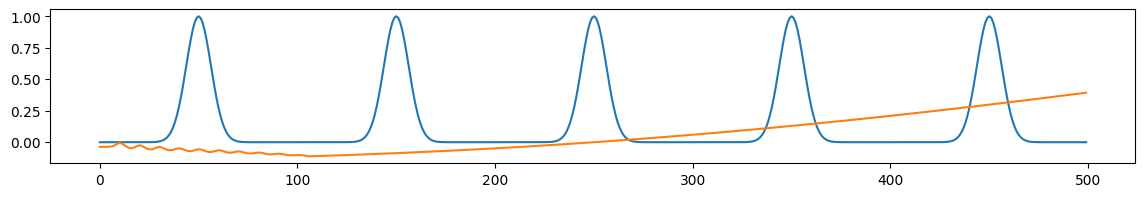

100%|██████████| 10/10 [00:00<00:00, 194.78it/s, loss=8.9e-7, lr=0.0272]


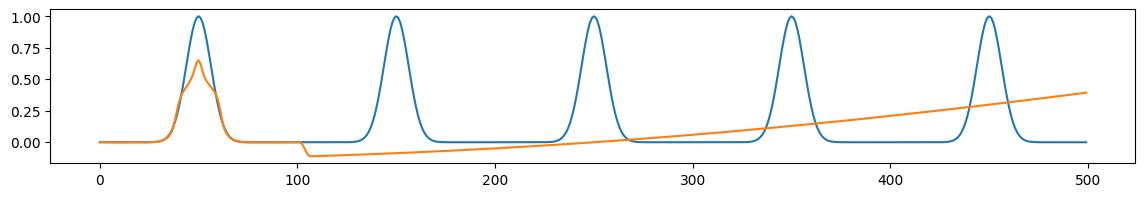

100%|██████████| 10/10 [00:00<00:00, 173.01it/s, loss=4.06e-9, lr=0.0248]


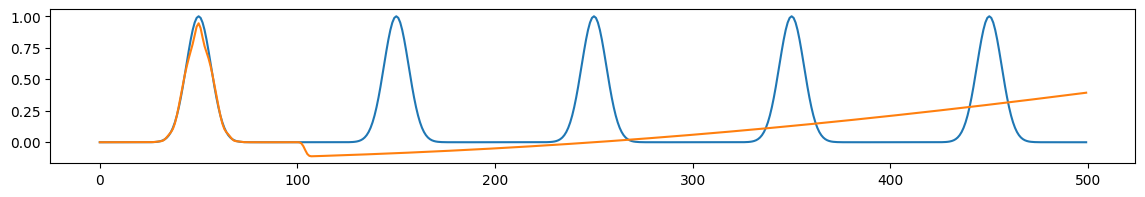

100%|██████████| 10/10 [00:00<00:00, 200.24it/s, loss=1.54e-10, lr=0.0227]


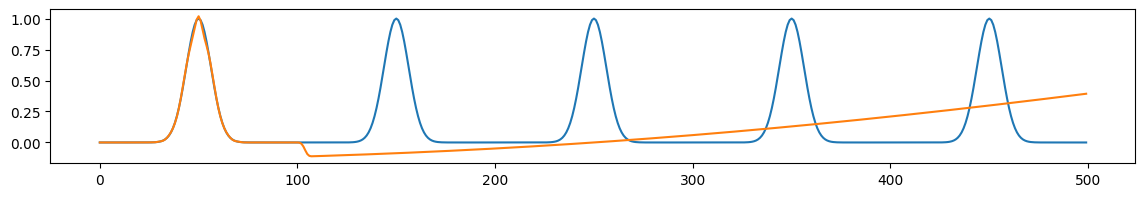

100%|██████████| 10/10 [00:00<00:00, 205.36it/s, loss=3.74e-11, lr=0.0207]


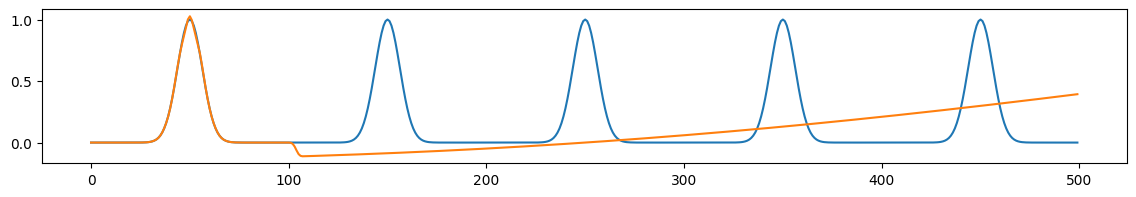

100%|██████████| 10/10 [00:00<00:00, 205.71it/s, loss=8.92e-12, lr=0.019]


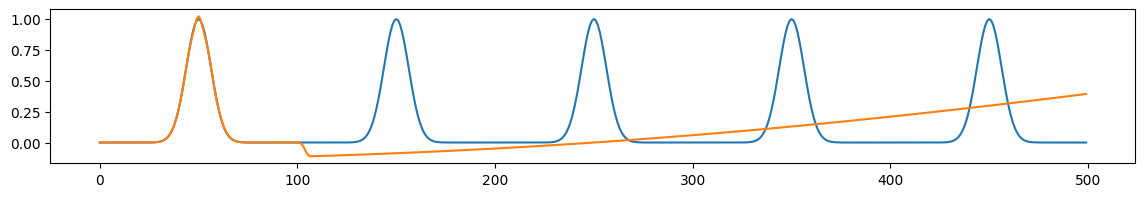

100%|██████████| 10/10 [00:00<00:00, 222.04it/s, loss=4.31e-12, lr=0.0173]


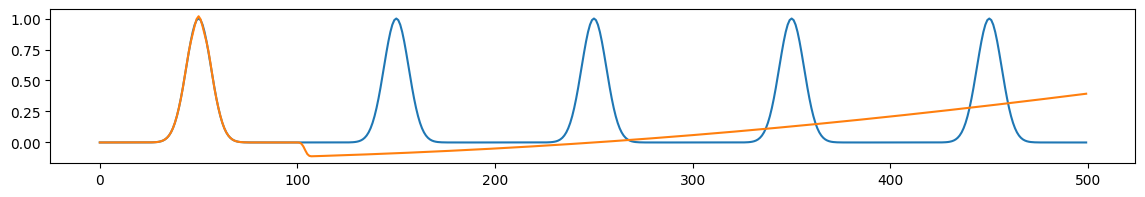

100%|██████████| 10/10 [00:00<00:00, 207.34it/s, loss=3.62e-12, lr=0.0158]


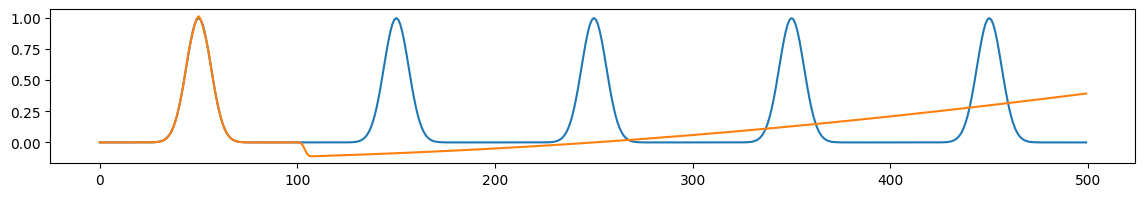

100%|██████████| 10/10 [00:00<00:00, 168.20it/s, loss=2.96e-12, lr=0.0145]


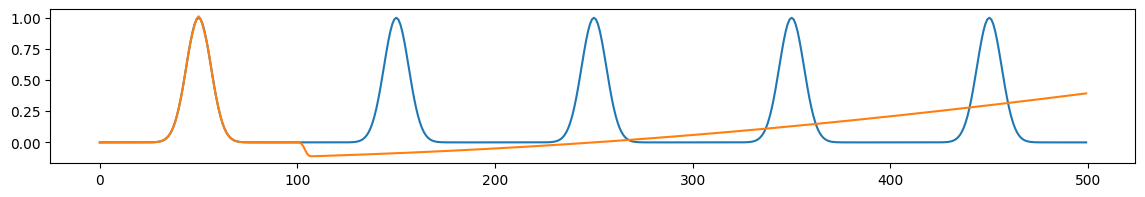

100%|██████████| 10/10 [00:00<00:00, 175.18it/s, loss=2.61e-12, lr=0.0132]


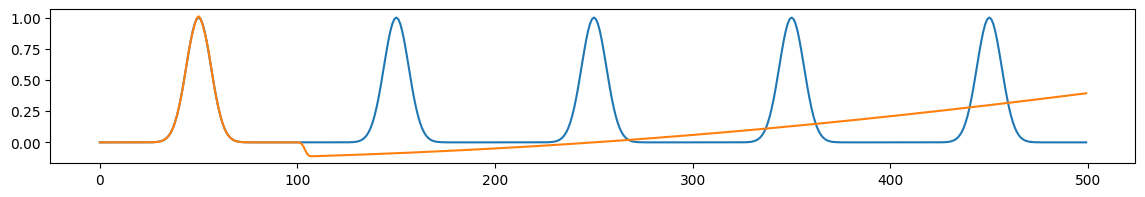

100%|██████████| 10/10 [00:00<00:00, 193.74it/s, loss=2.37e-12, lr=0.0121]


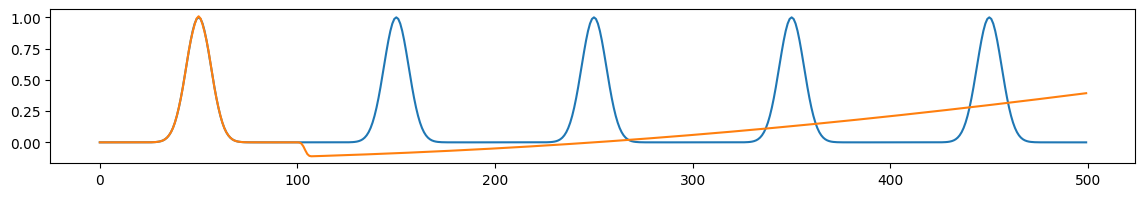

100%|██████████| 10/10 [00:00<00:00, 195.33it/s, loss=2.14e-12, lr=0.011]


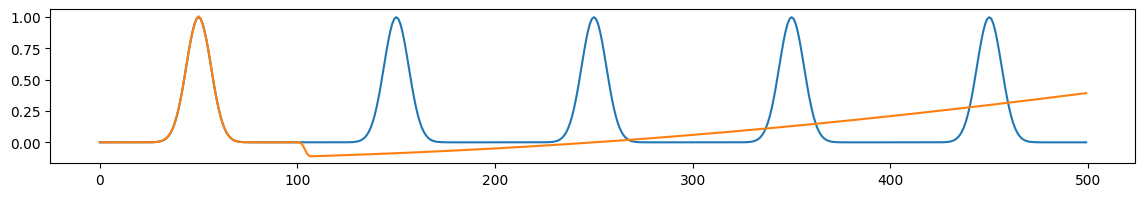

Training on task 1


100%|██████████| 10/10 [00:00<00:00, 179.70it/s, loss=1.16e-7, lr=0.0274]


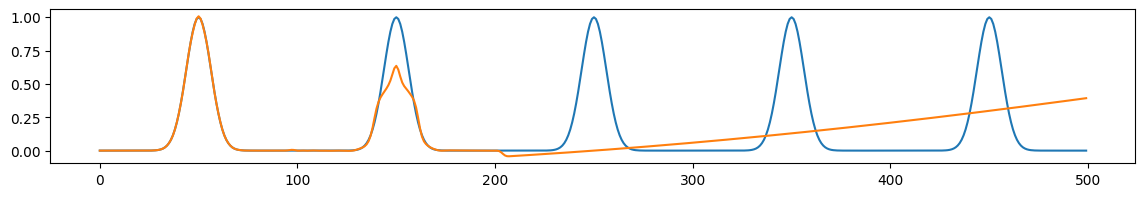

100%|██████████| 10/10 [00:00<00:00, 196.49it/s, loss=5.59e-6, lr=0.0251]


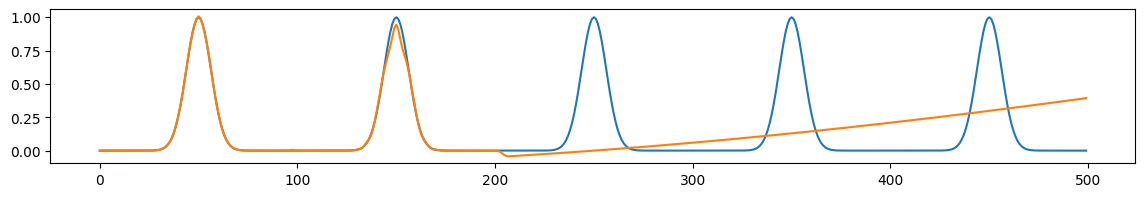

100%|██████████| 10/10 [00:00<00:00, 190.19it/s, loss=0.000319, lr=0.0229]


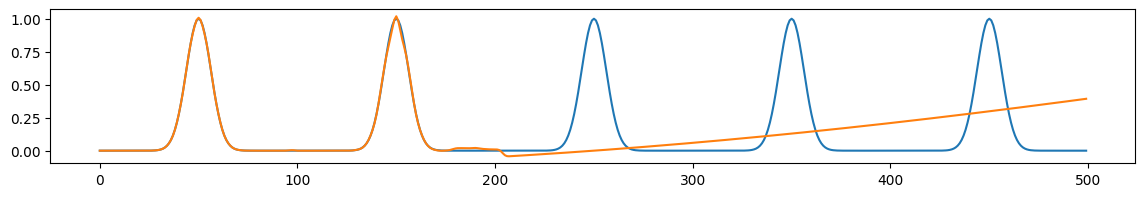

100%|██████████| 10/10 [00:00<00:00, 201.76it/s, loss=1.18e-8, lr=0.0209]


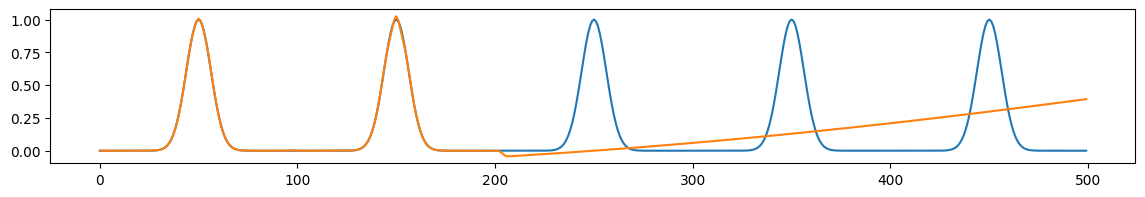

100%|██████████| 10/10 [00:00<00:00, 187.33it/s, loss=1.25e-10, lr=0.0191]


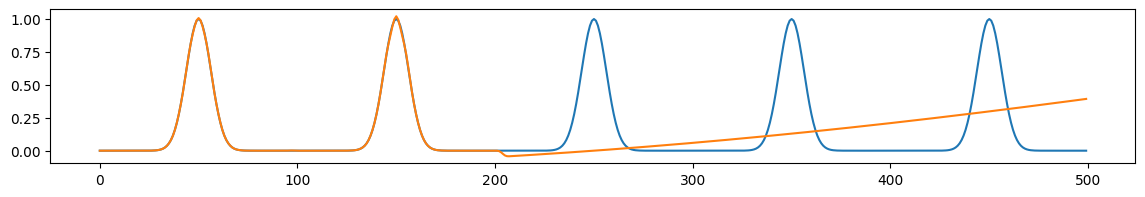

100%|██████████| 10/10 [00:00<00:00, 202.28it/s, loss=9.3e-12, lr=0.0175]


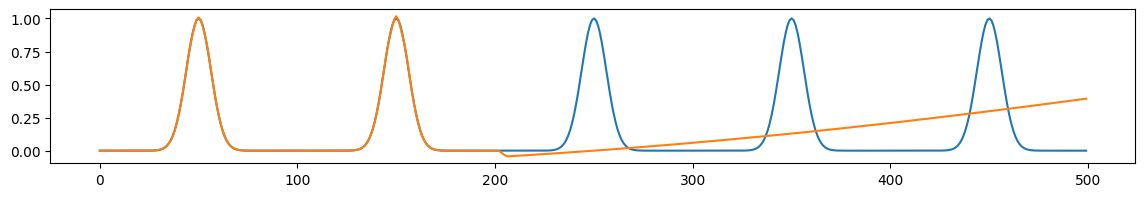

100%|██████████| 10/10 [00:00<00:00, 200.41it/s, loss=7.36e-12, lr=0.016]


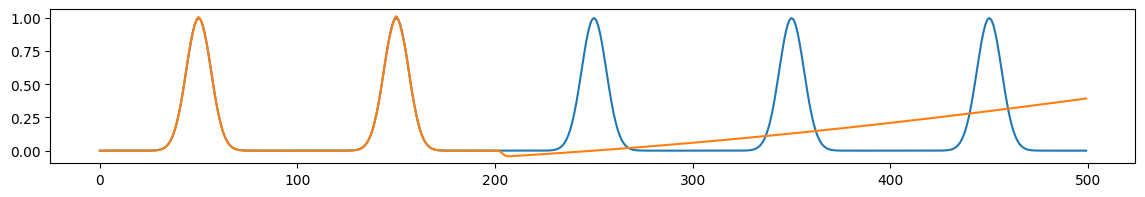

100%|██████████| 10/10 [00:00<00:00, 205.98it/s, loss=7.41e-12, lr=0.0146]


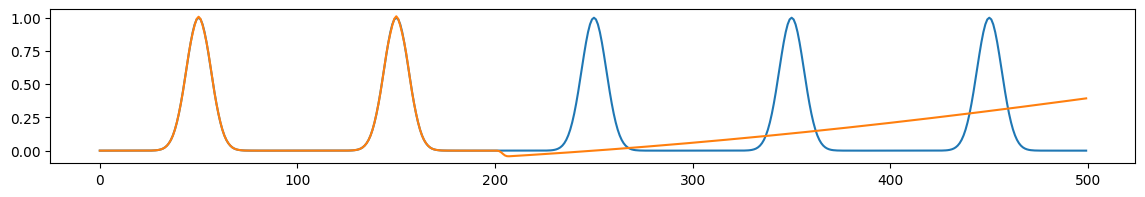

100%|██████████| 10/10 [00:00<00:00, 187.92it/s, loss=5.63e-12, lr=0.0134]


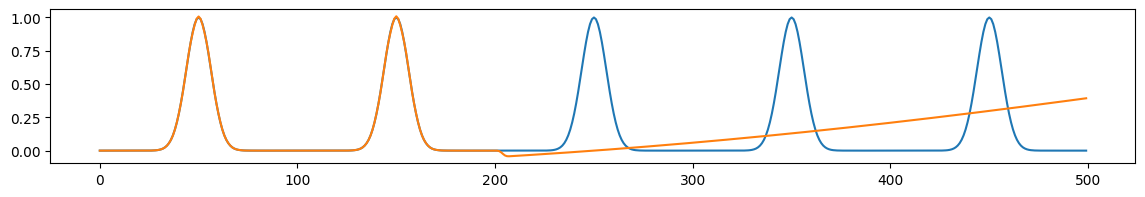

100%|██████████| 10/10 [00:00<00:00, 195.51it/s, loss=5.32e-12, lr=0.0122]


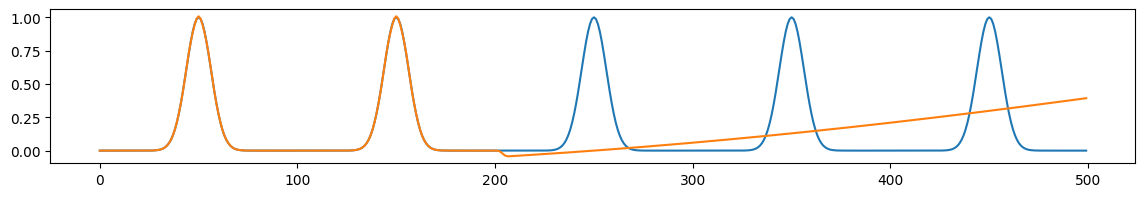

100%|██████████| 10/10 [00:00<00:00, 190.55it/s, loss=3.19e-12, lr=0.0112]


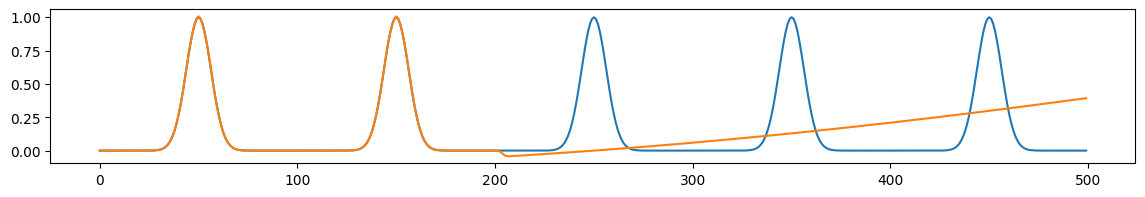

100%|██████████| 10/10 [00:00<00:00, 201.85it/s, loss=3.47e-12, lr=0.011]


Training on task 2


100%|██████████| 10/10 [00:00<00:00, 178.27it/s, loss=3.56e-6, lr=0.0277]


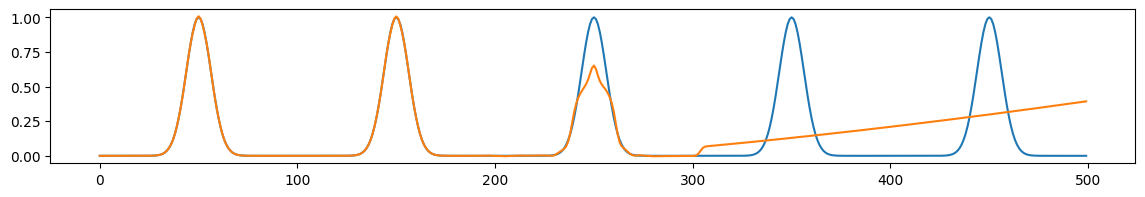

100%|██████████| 10/10 [00:00<00:00, 186.63it/s, loss=1.5e-6, lr=0.0253]


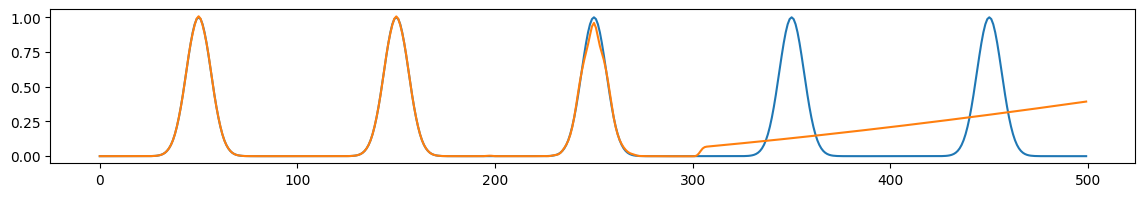

100%|██████████| 10/10 [00:00<00:00, 210.36it/s, loss=0.00157, lr=0.0232]


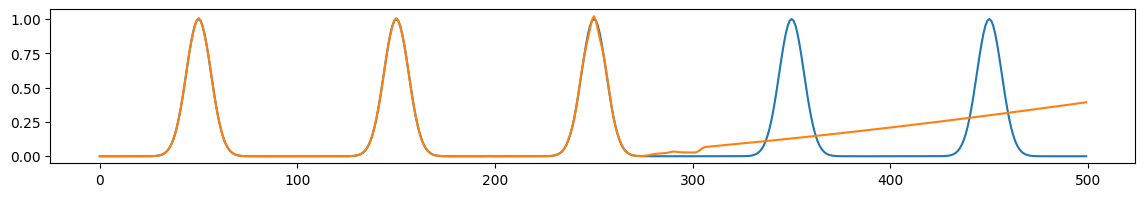

100%|██████████| 10/10 [00:00<00:00, 190.45it/s, loss=1.29e-7, lr=0.0212]


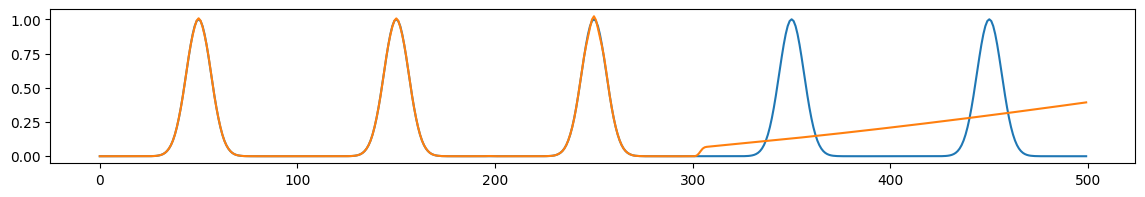

100%|██████████| 10/10 [00:00<00:00, 195.48it/s, loss=2.53e-11, lr=0.0193]


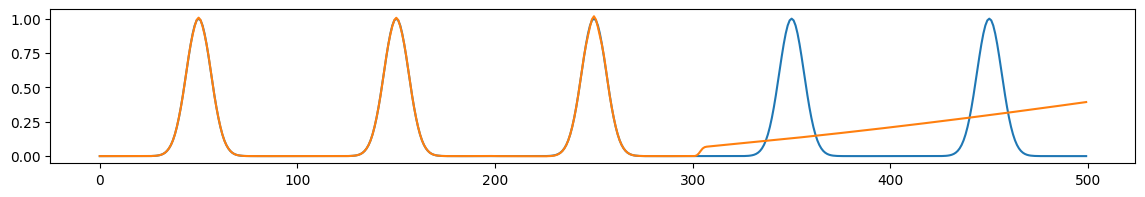

100%|██████████| 10/10 [00:00<00:00, 190.88it/s, loss=1.26e-10, lr=0.0177]


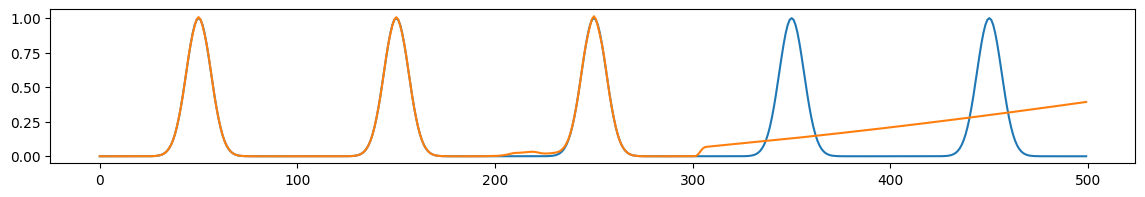

100%|██████████| 10/10 [00:00<00:00, 215.23it/s, loss=2.55e-9, lr=0.0161]


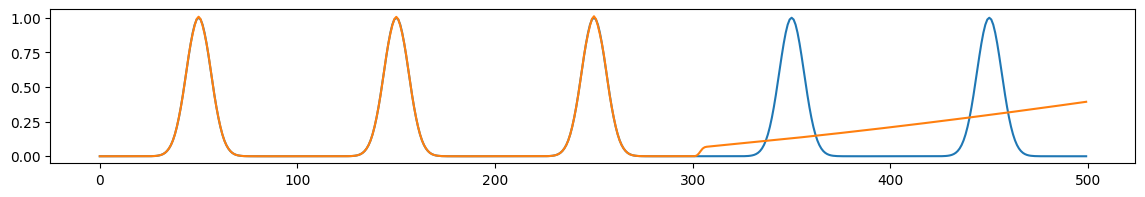

100%|██████████| 10/10 [00:00<00:00, 195.41it/s, loss=7.81e-8, lr=0.0148]


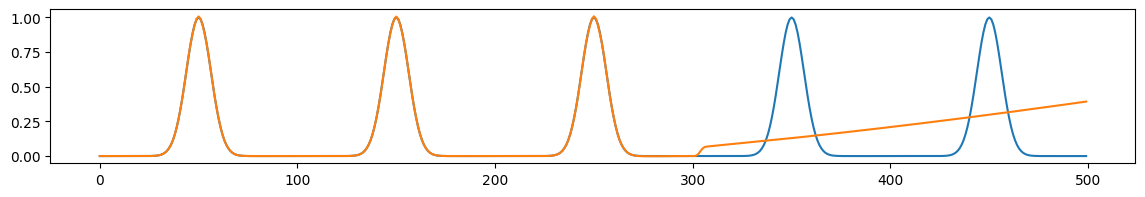

100%|██████████| 10/10 [00:00<00:00, 201.48it/s, loss=6.2e-7, lr=0.0135]


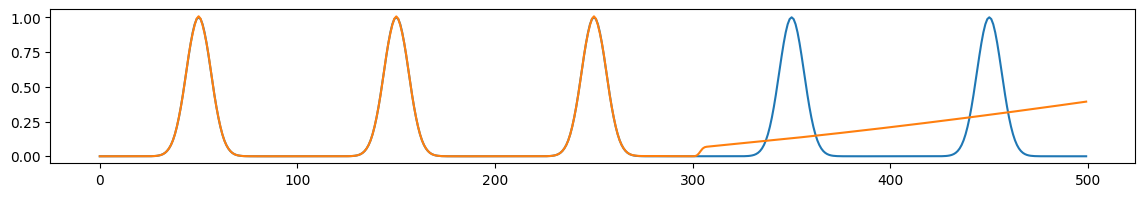

100%|██████████| 10/10 [00:00<00:00, 200.11it/s, loss=2.38e-8, lr=0.0123]


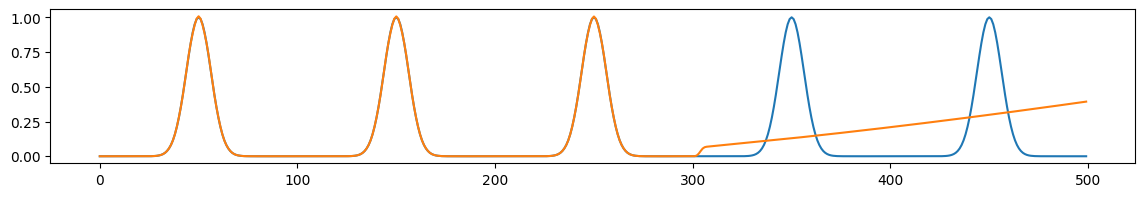

100%|██████████| 10/10 [00:00<00:00, 197.20it/s, loss=1.26e-11, lr=0.0113]


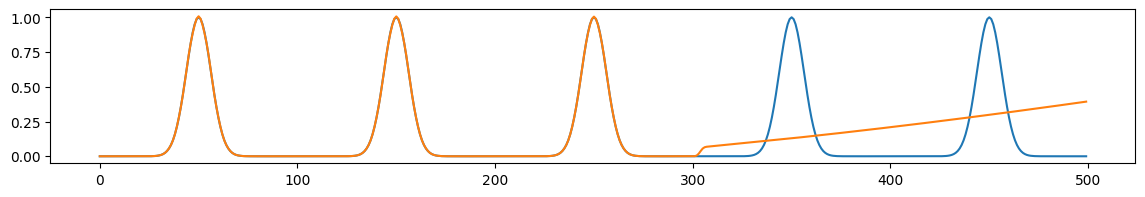

100%|██████████| 10/10 [00:00<00:00, 211.73it/s, loss=1.51e-12, lr=0.011]


Training on task 3


100%|██████████| 10/10 [00:00<00:00, 214.30it/s, loss=2.84e-5, lr=0.028]


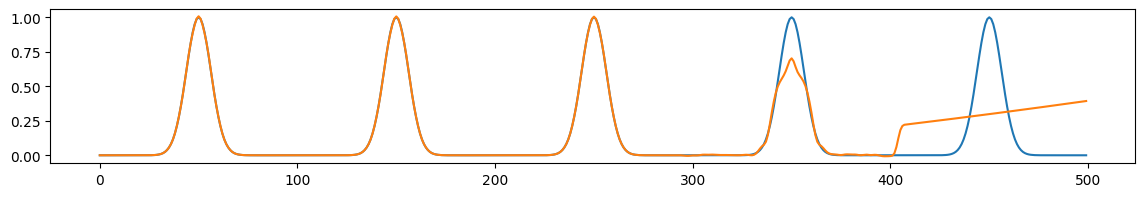

100%|██████████| 10/10 [00:00<00:00, 208.10it/s, loss=1.59e-7, lr=0.0256]


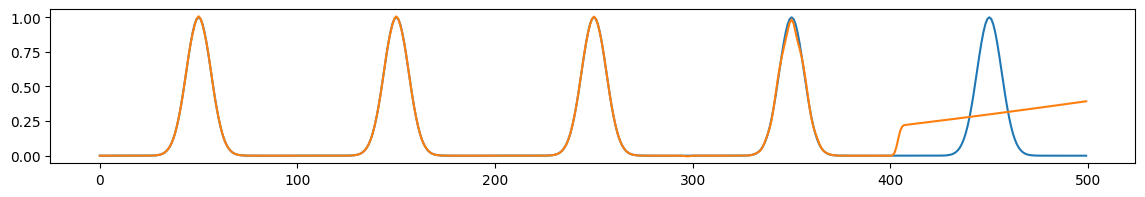

100%|██████████| 10/10 [00:00<00:00, 214.38it/s, loss=2.35e-8, lr=0.0234]


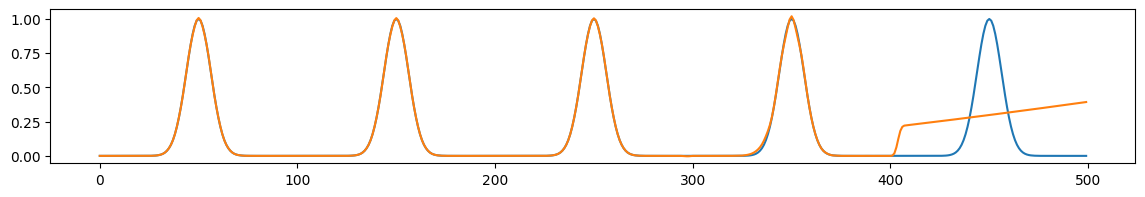

100%|██████████| 10/10 [00:00<00:00, 207.93it/s, loss=4.13e-9, lr=0.0214]


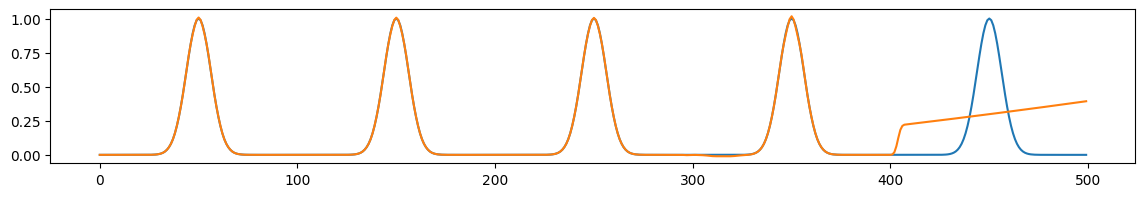

100%|██████████| 10/10 [00:00<00:00, 205.74it/s, loss=7.43e-10, lr=0.0195]


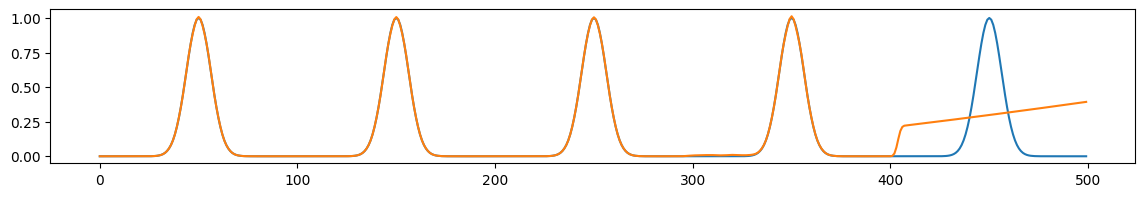

100%|██████████| 10/10 [00:00<00:00, 155.96it/s, loss=2.1e-10, lr=0.0178]


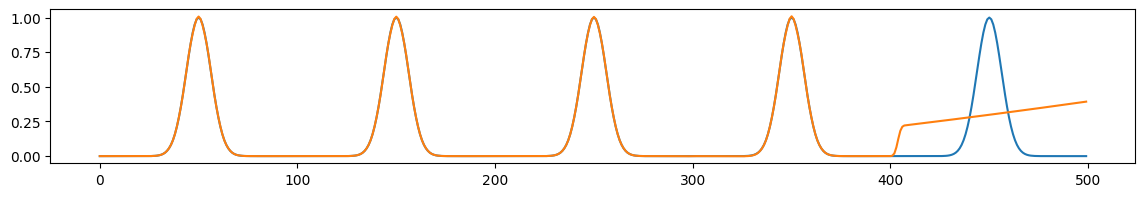

100%|██████████| 10/10 [00:00<00:00, 205.69it/s, loss=1.31e-10, lr=0.0163]


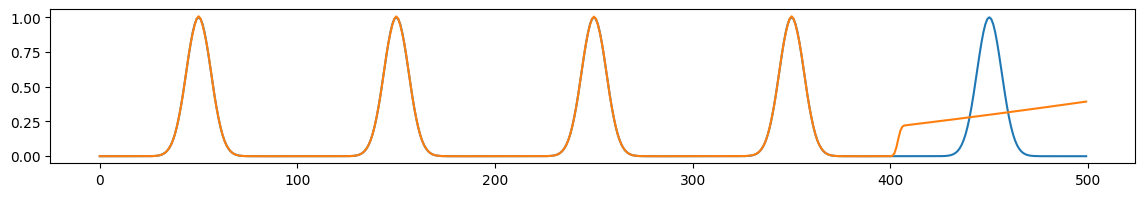

100%|██████████| 10/10 [00:00<00:00, 203.85it/s, loss=1.15e-10, lr=0.0149]


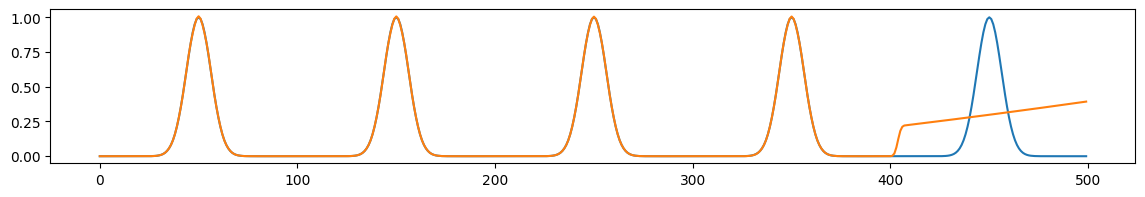

100%|██████████| 10/10 [00:00<00:00, 219.19it/s, loss=1.06e-10, lr=0.0136]


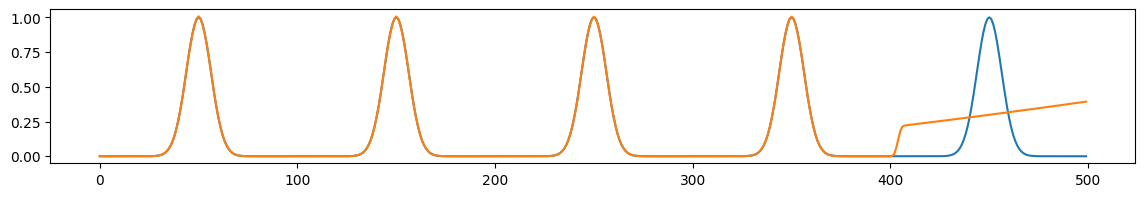

100%|██████████| 10/10 [00:00<00:00, 199.21it/s, loss=9.86e-11, lr=0.0125]


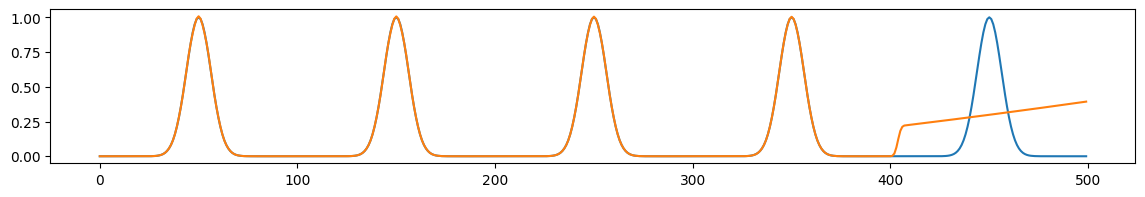

100%|██████████| 10/10 [00:00<00:00, 199.28it/s, loss=9.15e-11, lr=0.0114]


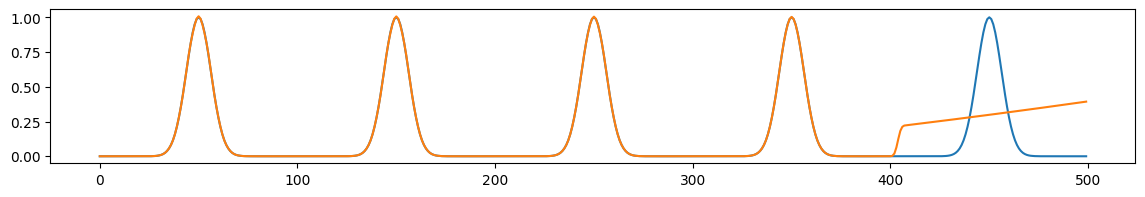

100%|██████████| 10/10 [00:00<00:00, 182.90it/s, loss=8.93e-11, lr=0.011]


Training on task 4


100%|██████████| 10/10 [00:00<00:00, 204.91it/s, loss=0.00265, lr=0.0283]


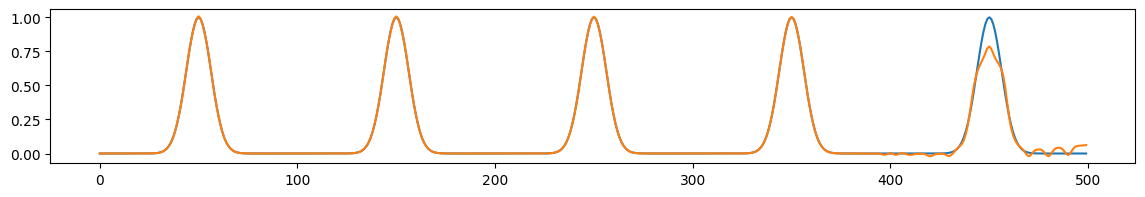

100%|██████████| 10/10 [00:00<00:00, 207.28it/s, loss=9.65e-6, lr=0.0258]


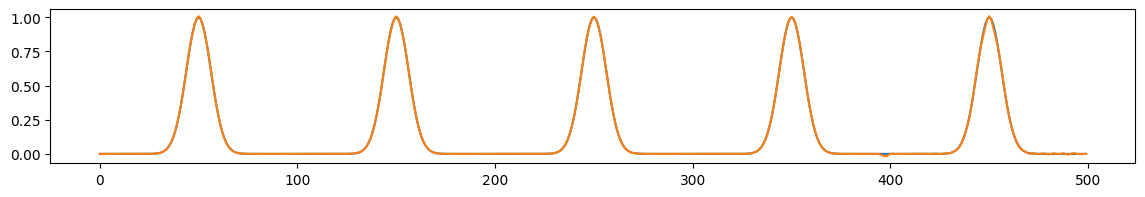

100%|██████████| 10/10 [00:00<00:00, 205.76it/s, loss=2.06e-6, lr=0.0236]


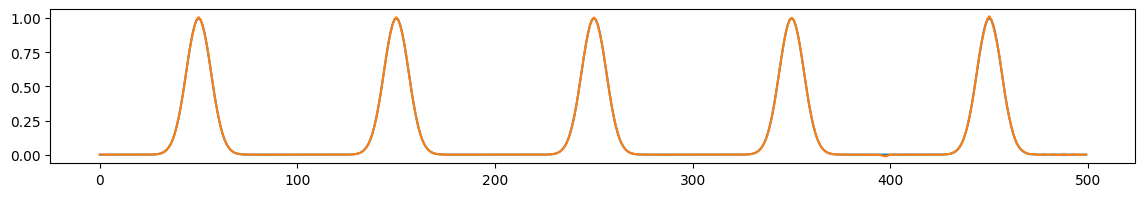

100%|██████████| 10/10 [00:00<00:00, 189.95it/s, loss=6.91e-7, lr=0.0216]


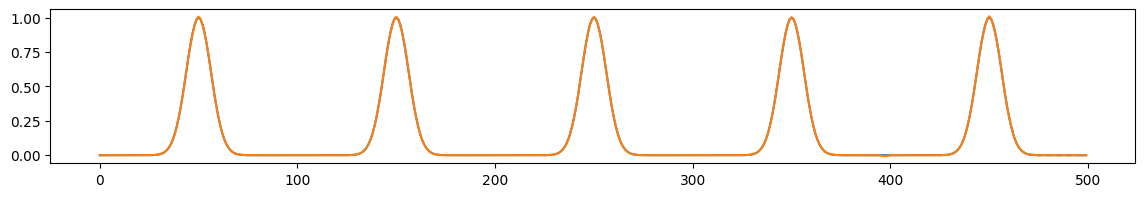

100%|██████████| 10/10 [00:00<00:00, 216.75it/s, loss=2.88e-7, lr=0.0197]


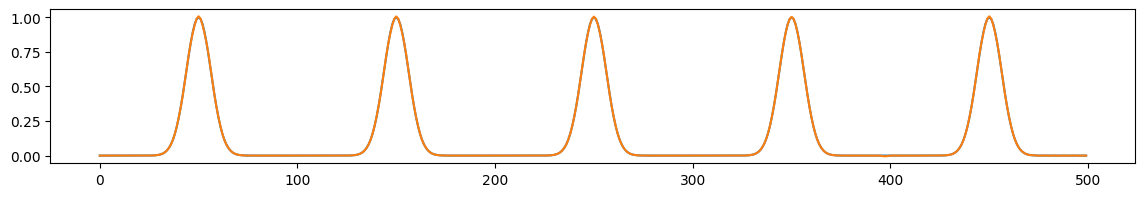

100%|██████████| 10/10 [00:00<00:00, 191.85it/s, loss=1.31e-7, lr=0.018]


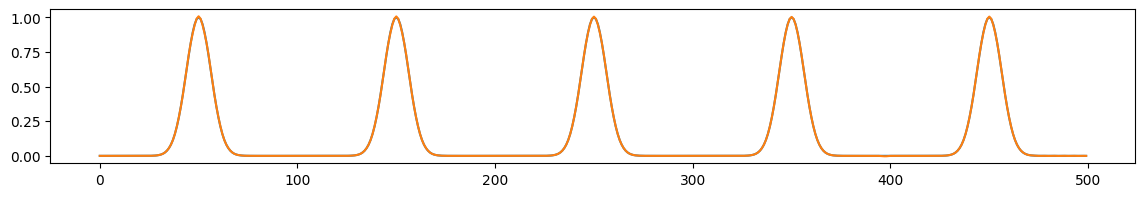

100%|██████████| 10/10 [00:00<00:00, 214.73it/s, loss=6.14e-8, lr=0.0165]


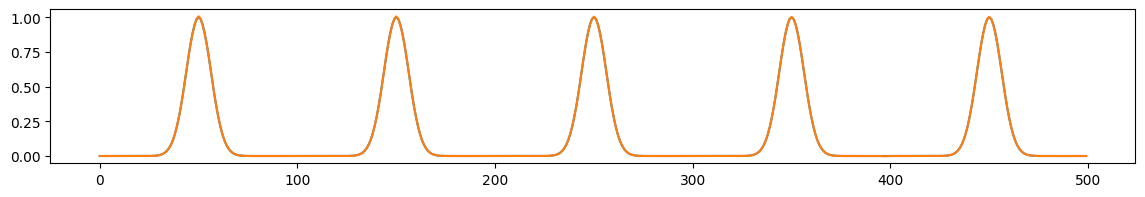

100%|██████████| 10/10 [00:00<00:00, 205.70it/s, loss=2.88e-8, lr=0.0151]


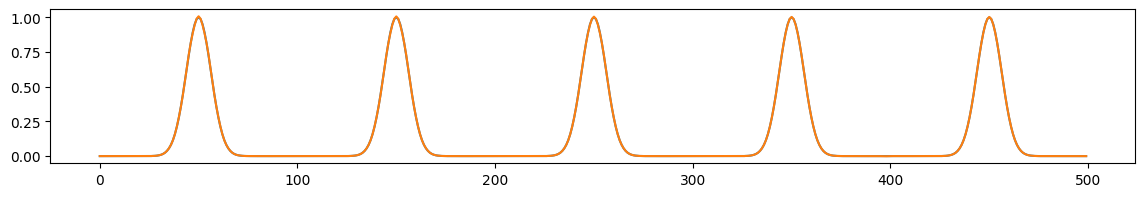

100%|██████████| 10/10 [00:00<00:00, 214.42it/s, loss=1.36e-8, lr=0.0138]


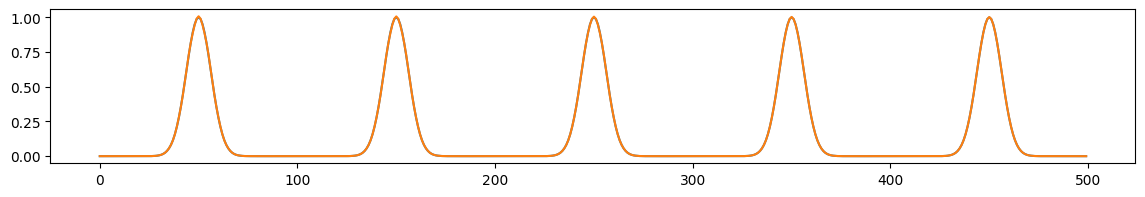

100%|██████████| 10/10 [00:00<00:00, 203.99it/s, loss=6.64e-9, lr=0.0126]


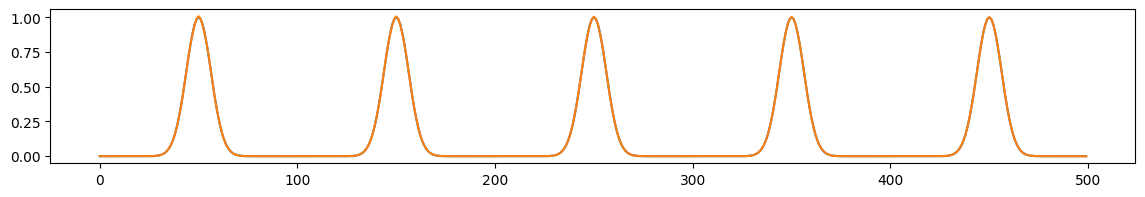

100%|██████████| 10/10 [00:00<00:00, 189.98it/s, loss=3.42e-9, lr=0.0115]


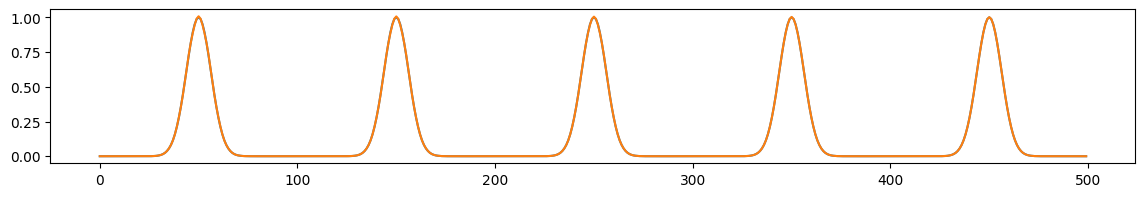

100%|██████████| 10/10 [00:00<00:00, 172.05it/s, loss=2.62e-9, lr=0.011]


In [14]:
for epochs, lr in zip([100], [3e-2]):
    models = [Efficient_KAN(), MLP()][:1]
    print(f'Using lr={lr} ------------------------------------')
    for model in [x.to(device) for x in models]:
        print(f'Training model={model.__class__.__name__}')
        for i, task in enumerate(train_loader_tasks):
            print(f'Training on task {i}')
            # TODO: substitute AdamW with Adam
            train(model, f'results/gaussian_peaks/inter/{model.__class__.__name__}', epochs=epochs,
                  start_epoch=i * epochs, optimizer=optim.Adam(model.parameters(), lr=lr),
                  on_epoch_end=onEpochEnd,
                  lr=lr, loader=task, task_id=i)